In [0]:
# https://tensorflow.org/install
!pip install tensorflow==2.0.0-alpha0 

In [0]:
from google.colab import drive
drive.mount("/content/drive")

In [0]:
# https://www.kaggle.com/c/dogs-vs-cats/data
train_file = "/content/drive/My Drive/Colab Notebooks/train.zip"

In [0]:
import zipfile

with zipfile.ZipFile(train_file, 'r') as z:
    z.extractall()

In [0]:
import os
import cv2

def load_image(file_path):
    return cv2.imread(file_path)

def extract_label(file_name):
    return 1 if "dog" in file_name else 0

train_path = "./train/"
image_files = os.listdir(train_path)
train_images = [load_image(train_path + file) for file in image_files]
train_labels = [extract_label(file) for file in image_files]

In [0]:
def preprocess_image(img, side=96):
    min_side = min(img.shape[0], img.shape[1])
    img = img[:min_side, :min_side]
    img = cv2.resize(img, (side,side))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img / 255.0

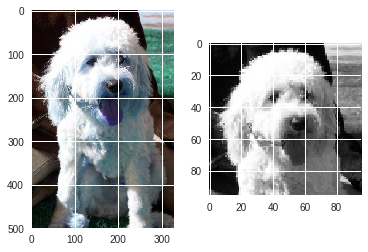

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

preview_index = 21000
plt.subplot(1,2,1)
plt.imshow(train_images[preview_index])
plt.subplot(1,2,2)
plt.imshow(preprocess_image(train_images[preview_index]), cmap="gray")

In [0]:
for i in range(len(train_images)):
    train_images[i] = preprocess_image(train_images[i])

In [31]:
import numpy as np

train_images = np.expand_dims(train_images, axis=-1)
train_labels = np.array(train_labels)
print(train_images.shape, train_labels.shape)

(25000, 96, 96, 1) (25000,)


In [35]:
import tensorflow as tf
print("Tensorflow:", tf.__version__)

layers = [
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
]

model = tf.keras.Sequential(layers)
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=5, batch_size=50)
model.save_weights("model.tf")

Tensorflow: 2.0.0-alpha0
Epoch 1/5
25000/25000 [==============================] - 313s 13ms/sample - loss: 0.6514 - sparse_categorical_accuracy: 0.6040
Epoch 2/5
25000/25000 [==============================] - 313s 13ms/sample - loss: 0.5080 - sparse_categorical_accuracy: 0.7517
Epoch 3/5
25000/25000 [==============================] - 314s 13ms/sample - loss: 0.3883 - sparse_categorical_accuracy: 0.8235
Epoch 4/5
25000/25000 [==============================] - 315s 13ms/sample - loss: 0.3247 - sparse_categorical_accuracy: 0.8542
Epoch 5/5
25000/25000 [==============================] - 315s 13ms/sample - loss: 0.2696 - sparse_categorical_accuracy: 0.8838


In [0]:
from google.colab import files
uploads = files.upload()

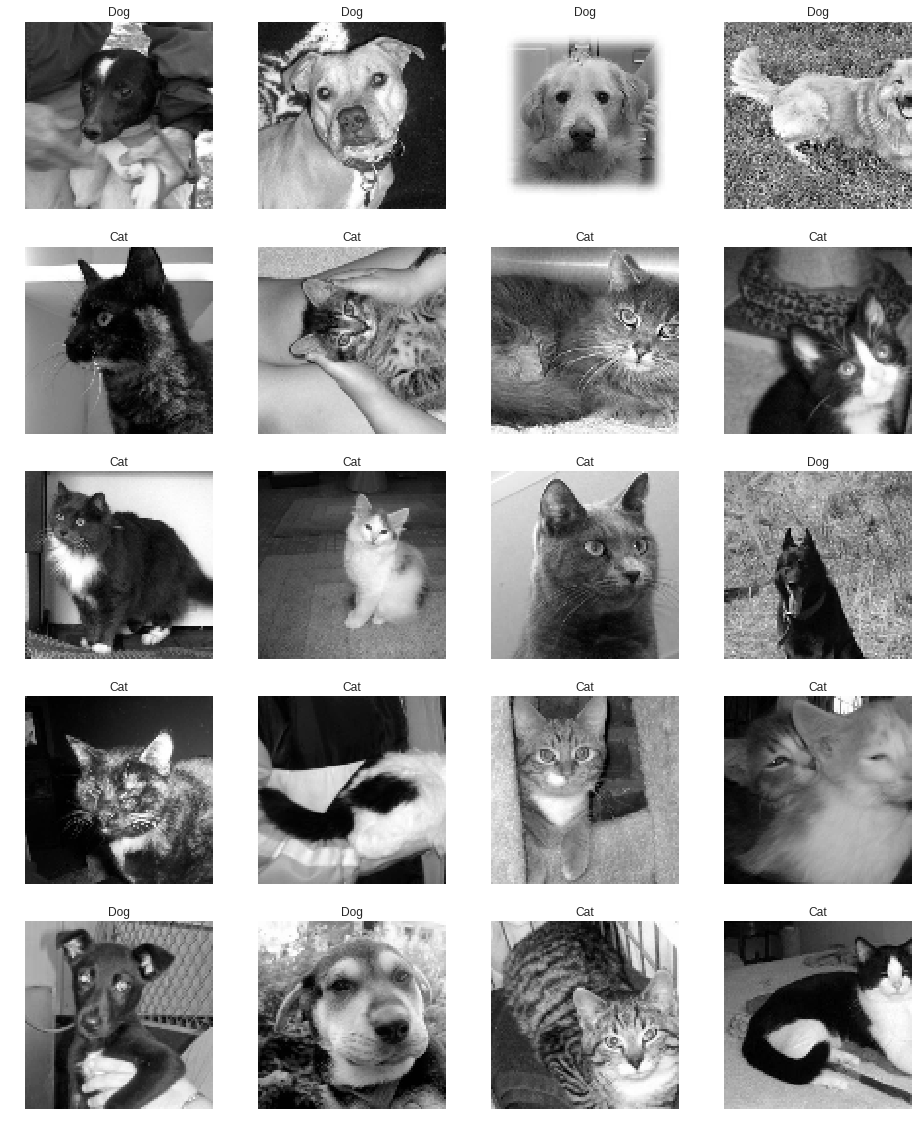

In [40]:
eval_images = [preprocess_image(load_image(file)) for file in uploads.keys()]
eval_model = tf.keras.Sequential(layers)
eval_model.load_weights("model.tf")
eval_predictions = eval_model.predict(np.expand_dims(eval_images, axis=-1))

cols = 4
rows = np.ceil(len(eval_images)/cols)
fig = plt.gcf()
fig.set_size_inches(cols * 4, rows * 4)
for i in range(len(eval_images)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(eval_images[i], cmap="gray")
    plt.title("Dog" if np.argmax(eval_predictions[i])==1 else "Cat")
    plt.axis('off')

In [46]:
!ls

10.jpg	14.jpg	18.jpg	2.jpg  6.jpg  checkpoint		    sample_data
11.jpg	15.jpg	19.jpg	3.jpg  7.jpg  drive			    train
12.jpg	16.jpg	1.jpg	4.jpg  8.jpg  model.tf.data-00000-of-00001
13.jpg	17.jpg	20.jpg	5.jpg  9.jpg  model.tf.index


In [0]:
files.download("model.tf.index")